In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import sys
sys.path.insert(0,'/content/drive/MyDrive/Colab Notebooks/PhD GO Experiments/GO characterization')

In [2]:
n_classes = 2
IMG_HEIGHT = 512
IMG_WIDTH  = 512
IMG_CHANNELS = 1

from u_net_model_5x5 import multi_unet_model
def get_model():
  return multi_unet_model(n_classes=n_classes, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)

model = get_model()
model.load_weights('/content/drive/MyDrive/Colab Notebooks/PhD GO Experiments/GO characterization/Results/Weights/5x5/Weights_CV_4.hdf5')

In [3]:
def crop_img(image, q_img):
  if (q_img == 1):
    img_vol = image[0:512, 0:512]
  if (q_img == 2):
    img_vol = image[0:512, 512:1024]
  if (q_img == 3):
    img_vol = image[0:512, 768:1280]
  if (q_img == 4):
    img_vol = image[448:960, 0:512]
  if (q_img == 5):
    img_vol = image[448:960, 512:1024]
  if (q_img == 6):
    img_vol = image[448:960, 768:1280]
  return img_vol

In [4]:
large_img = cv2.imread('/content/drive/MyDrive/Colab Notebooks/U-net Graphene Segmentation Final/Data/original data/ori/test_production/2.tif', 0)
large_img = np.array(large_img)
mask = cv2.imread('/content/drive/MyDrive/Colab Notebooks/U-net Graphene Segmentation Final/Data/original data/mask/test_production/2.tif', 0)
mask = np.array(mask)

In [5]:
#Normalizing large image
np.zeros(())

img_norm = large_img/255

for q_img in range(1,7):
  img_crop = crop_img(img_norm, q_img)
  img = np.expand_dims(img_crop, 2)
  img = img[:,:,0][:,:,None]
  img = np.expand_dims(img, 0)

  #U-net output
  prediction = model.predict(img)
  predicted_img = np.argmax(prediction, axis=3)[0,:,:]

  if q_img == 1:
    predicted_h = predicted_img
  elif q_img == 2:
    predicted_h = np.concatenate((predicted_h, predicted_img), axis=1)
  elif q_img == 3:
    predicted_h = np.concatenate((predicted_h, predicted_img[:,256:]), axis=1)
  elif q_img == 4:
    predicted_l = predicted_img
  elif q_img == 5:
    predicted_l = np.concatenate((predicted_l, predicted_img), axis=1)
  else:
    predicted_l = np.concatenate((predicted_l, predicted_img[:,256:]), axis=1)

predicted_final = np.concatenate((predicted_h, predicted_l[64:,:]), axis=0)
# predicted_final = np.concatenate((predicted_final, meta_data), axis=0)
predicted_final.shape

1/1 [==============================] - 3s 3s/step


(960, 1280)

In [6]:
def std_by_class(img, prediction):
  img_rs = np.reshape(img, (960,1280))
  array_true_px = img_rs * (prediction-1) * -1
  array_false_px = img_rs * prediction

  #Average Calculum
  avg_true = sum(sum(array_true_px)) / np.count_nonzero(prediction == 0)
  avg_false = sum(sum(array_false_px)) / np.count_nonzero(prediction == 1)

  #Standard Deviation Calculum
  sigma_true = 0
  sigma_false = 0
  h, w = img.shape
  for i in range(0,h):
    for j in range(0, w):
      if prediction[i,j] == 0:
        sigma_true = sigma_true + ((img_rs[i,j] - avg_true)**2)
      else:
        sigma_false = sigma_false + ((img_rs[i,j] - avg_false)**2)

  std_true = np.sqrt(sigma_true / np.count_nonzero(prediction == 0))
  std_false = np.sqrt(sigma_false / np.count_nonzero(prediction == 1))

  return std_true, std_false, avg_true, avg_false


def std_pixel_verification(img, prediction):
  std_true, std_false, avg_true, avg_false = std_by_class(img, prediction)

  img_std = np.zeros([960, 1280], dtype=np.uint8) + prediction

  h, w = img.shape
  for i in range(0,h):
    for j in range(0,w):
      if prediction[i,j] == 0 and img[i,j] >= avg_true + 0.8 * std_true:
        img_std[i,j] = 1
      if prediction[i,j] == 1 and img[i,j] <= avg_false - 4.5 * std_false:
        img_std[i,j] = 0

  return img_std


  def std_calc(metric):
    avg_metric = sum(metric) / len(metric)
    sigma = 0
    for val in metric:
      sigma = sigma + (val - avg_metric)**2
    return np.sqrt(sigma/len(metric))

In [7]:
 ##################################################################################################################
#CLUSTERING, MEASURAMENT AND IDENTIFICATION
from image_manipulation import measurament # maker_label

labels, df = measurament(predicted_final)

image = (255*labels/np.max(labels)).astype('uint8')
window_name = 'Image'
font = cv2.FONT_HERSHEY_SIMPLEX
fontScale = 0.3
thickness = 1

for i in range(1,len(df)):
  org = (df['centroid'][i][0], df['centroid'][i][1])
  color = (255, 255, 255)
  image = cv2.putText(image, '{}'.format(i), org, font,
                    fontScale, (100, 100, 255), thickness+1, cv2.LINE_AA)
  image = cv2.putText(image, '{}'.format(i), org, font,
                    fontScale, color, thickness, cv2.LINE_AA)

cv2.imwrite('/content/drive/MyDrive/Colab Notebooks/PhD GO Experiments/Image_Processed.png', image)

True

In [8]:
df_vol = df
condition_major = (np.average(df_vol.Area)+2*np.std(df_vol.Area))
condition_minor = (np.average(df_vol.Area)-2*np.std(df_vol.Area))
df_vol.drop(df_vol[df_vol.Area > condition_major].index, inplace=True)
df_vol.drop(df_vol[df_vol.Area < condition_minor].index, inplace=True)
df_vol.drop(df_vol[df_vol.Area <= 0].index, inplace=True)
df_vol

,centroid,Area,equivalent_diameter,orientation,MajorAxisLength,MinorAxisLength,Perimeter
1,"(0, 0)",2,1.595769,0.000000,2.000000,0.000000,0.000000
2,"(22, 0)",18,4.787307,90.000032,20.752510,0.000000,16.000000
3,"(42, 0)",11,3.742410,90.000032,12.649111,0.000000,9.000000
4,"(135, 0)",9,3.385138,90.000032,10.327956,0.000000,7.000000
5,"(180, 0)",12,3.908820,90.000032,13.808210,0.000000,10.000000
...,...,...,...,...,...,...,...
194,"(499, 950)",839,32.684063,87.706962,59.245393,22.803734,190.953319
195,"(701, 950)",543,26.293898,87.985827,32.551836,22.578767,96.905592
196,"(0, 943)",1,1.128379,45.000016,0.000000,0.000000,0.000000
197,"(381, 959)",2,1.595769,90.000032,2.000000,0.000000,0.000000


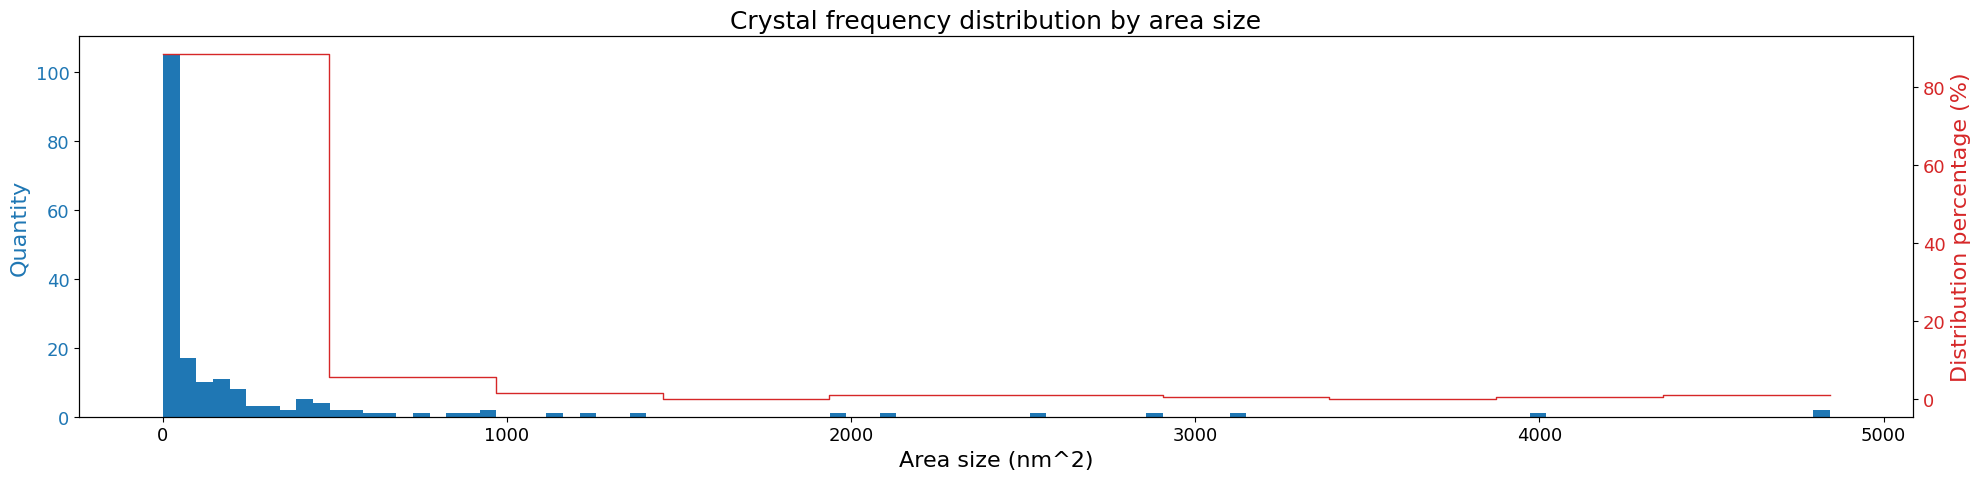

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import itertools

n_bins = 100

plt.rcParams['font.size'] = '13'

fig, ax1 = plt.subplots(figsize=(20,5))
plt.title('Crystal frequency distribution by area size', fontsize=18)

color = 'tab:blue'
ax1.set_xlabel('Area size (nm^2)', fontsize=16)
ax1.set_ylabel('Quantity', color=color, fontsize=16)
ax1.hist(df_vol['Area'], bins=n_bins)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

count, bins_count = np.histogram(df_vol['Area'], bins=n_bins)
if n_bins <= 10:
  count_vol = np.array(count)/len(df['Area'])
  count_vol = list(itertools.chain([count_vol[0]], count_vol))

else:
  count_vol = list(np.zeros(int(len(count)/10), dtype=float))

  for i in range(0,int(len(count)/10), 1):
    if i==0:
      count_vol[i] += sum(count[0:10])
    else:
      count_vol[i] += sum(count[i*10:(i*10)+10])
  count_vol = np.array(count_vol)/len(df['Area'])
  count_vol = count_vol *100
  count_vol = list(itertools.chain([count_vol[0]], count_vol))


if n_bins/10 == 1:
  interval_max = 10
else:
  interval_max = int(n_bins/10)

interval = max(df_vol.Area)/10
x_axis = [0]
for i in range(1, interval_max + 1):
  x_axis.append(i*interval)

color = 'tab:red'
ax2.set_ylabel('Distribution percentage (%)', color=color, fontsize=16)  # we already handled the x-label with ax1
ax2.step(x_axis, count_vol, color=color, linewidth=1)
ax2.tick_params(axis='y', labelcolor=color)


fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.savefig('/content/drive/MyDrive/Colab Notebooks/U-net Graphene Segmentation Final/Graphic.png')
plt.show()

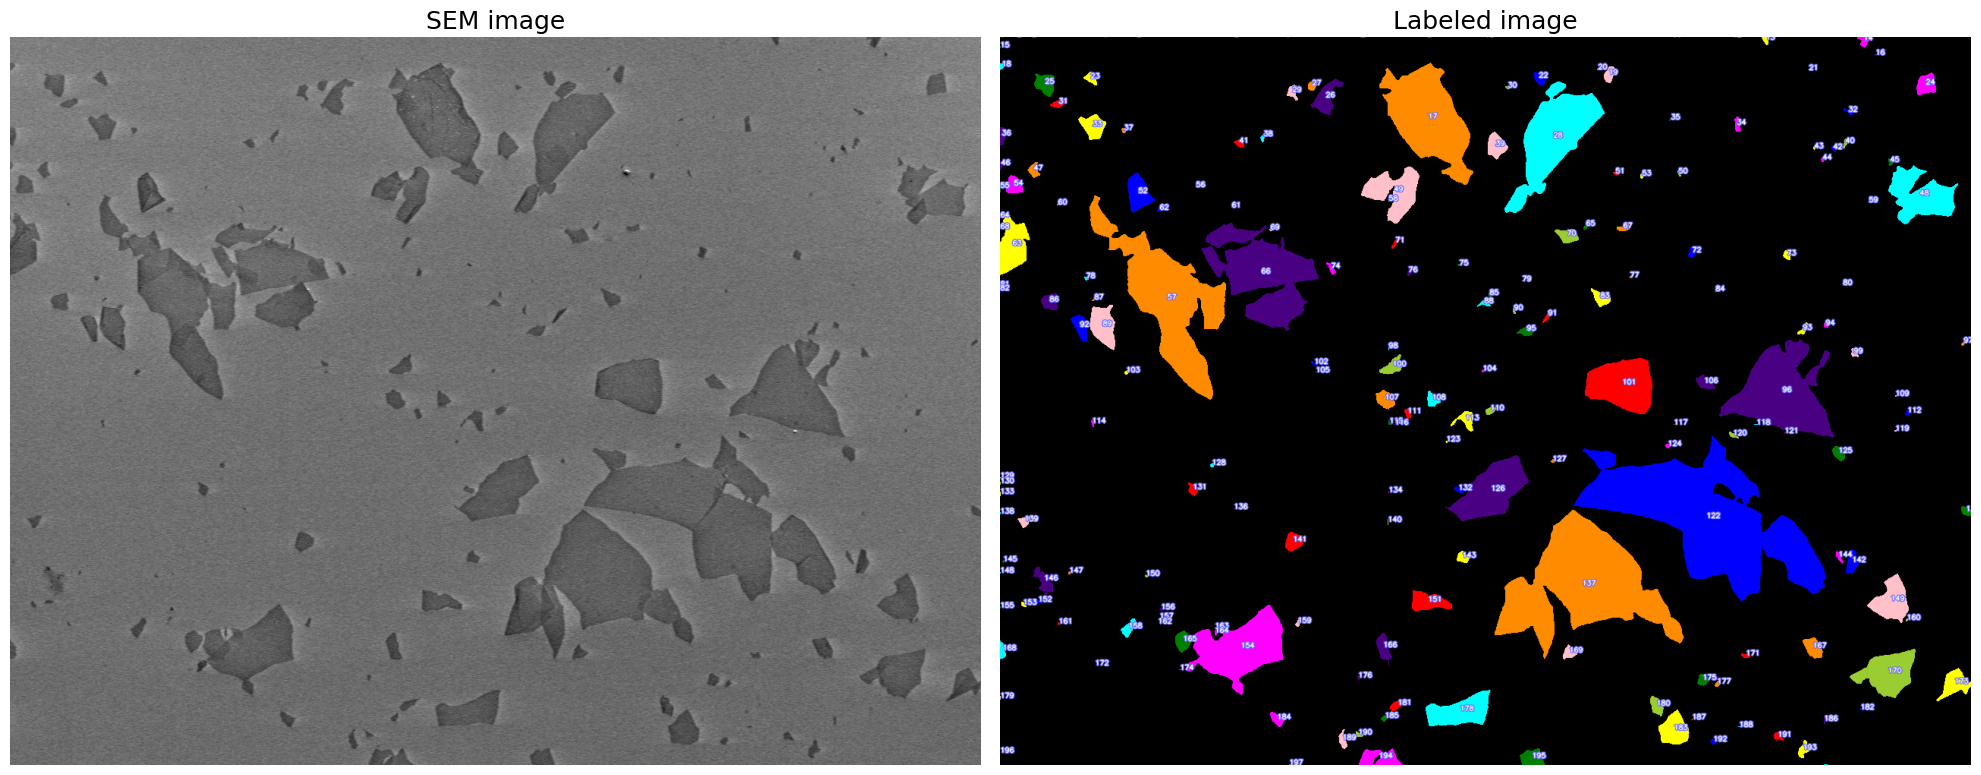

In [10]:
#CLUSTERING, MEASURAMENT AND IDENTIFICATION
from skimage import io
from image_manipulation import measurament

labels, df = measurament(predicted_final)

plt.figure(figsize=(20,10))
plt.subplot(121)
plt.title('SEM image', fontsize=18)
plt.imshow(large_img[:960, :], cmap='gray')
plt.axis('off')

plt.subplot(122)
plt.title('Labeled image', fontsize=18)
plt.imshow(image, cmap='brg')
plt.axis('off')

plt.tight_layout()

plt.savefig('/content/drive/MyDrive/Colab Notebooks/U-net Graphene Segmentation Final/Image_Proc2.png')
plt.show()

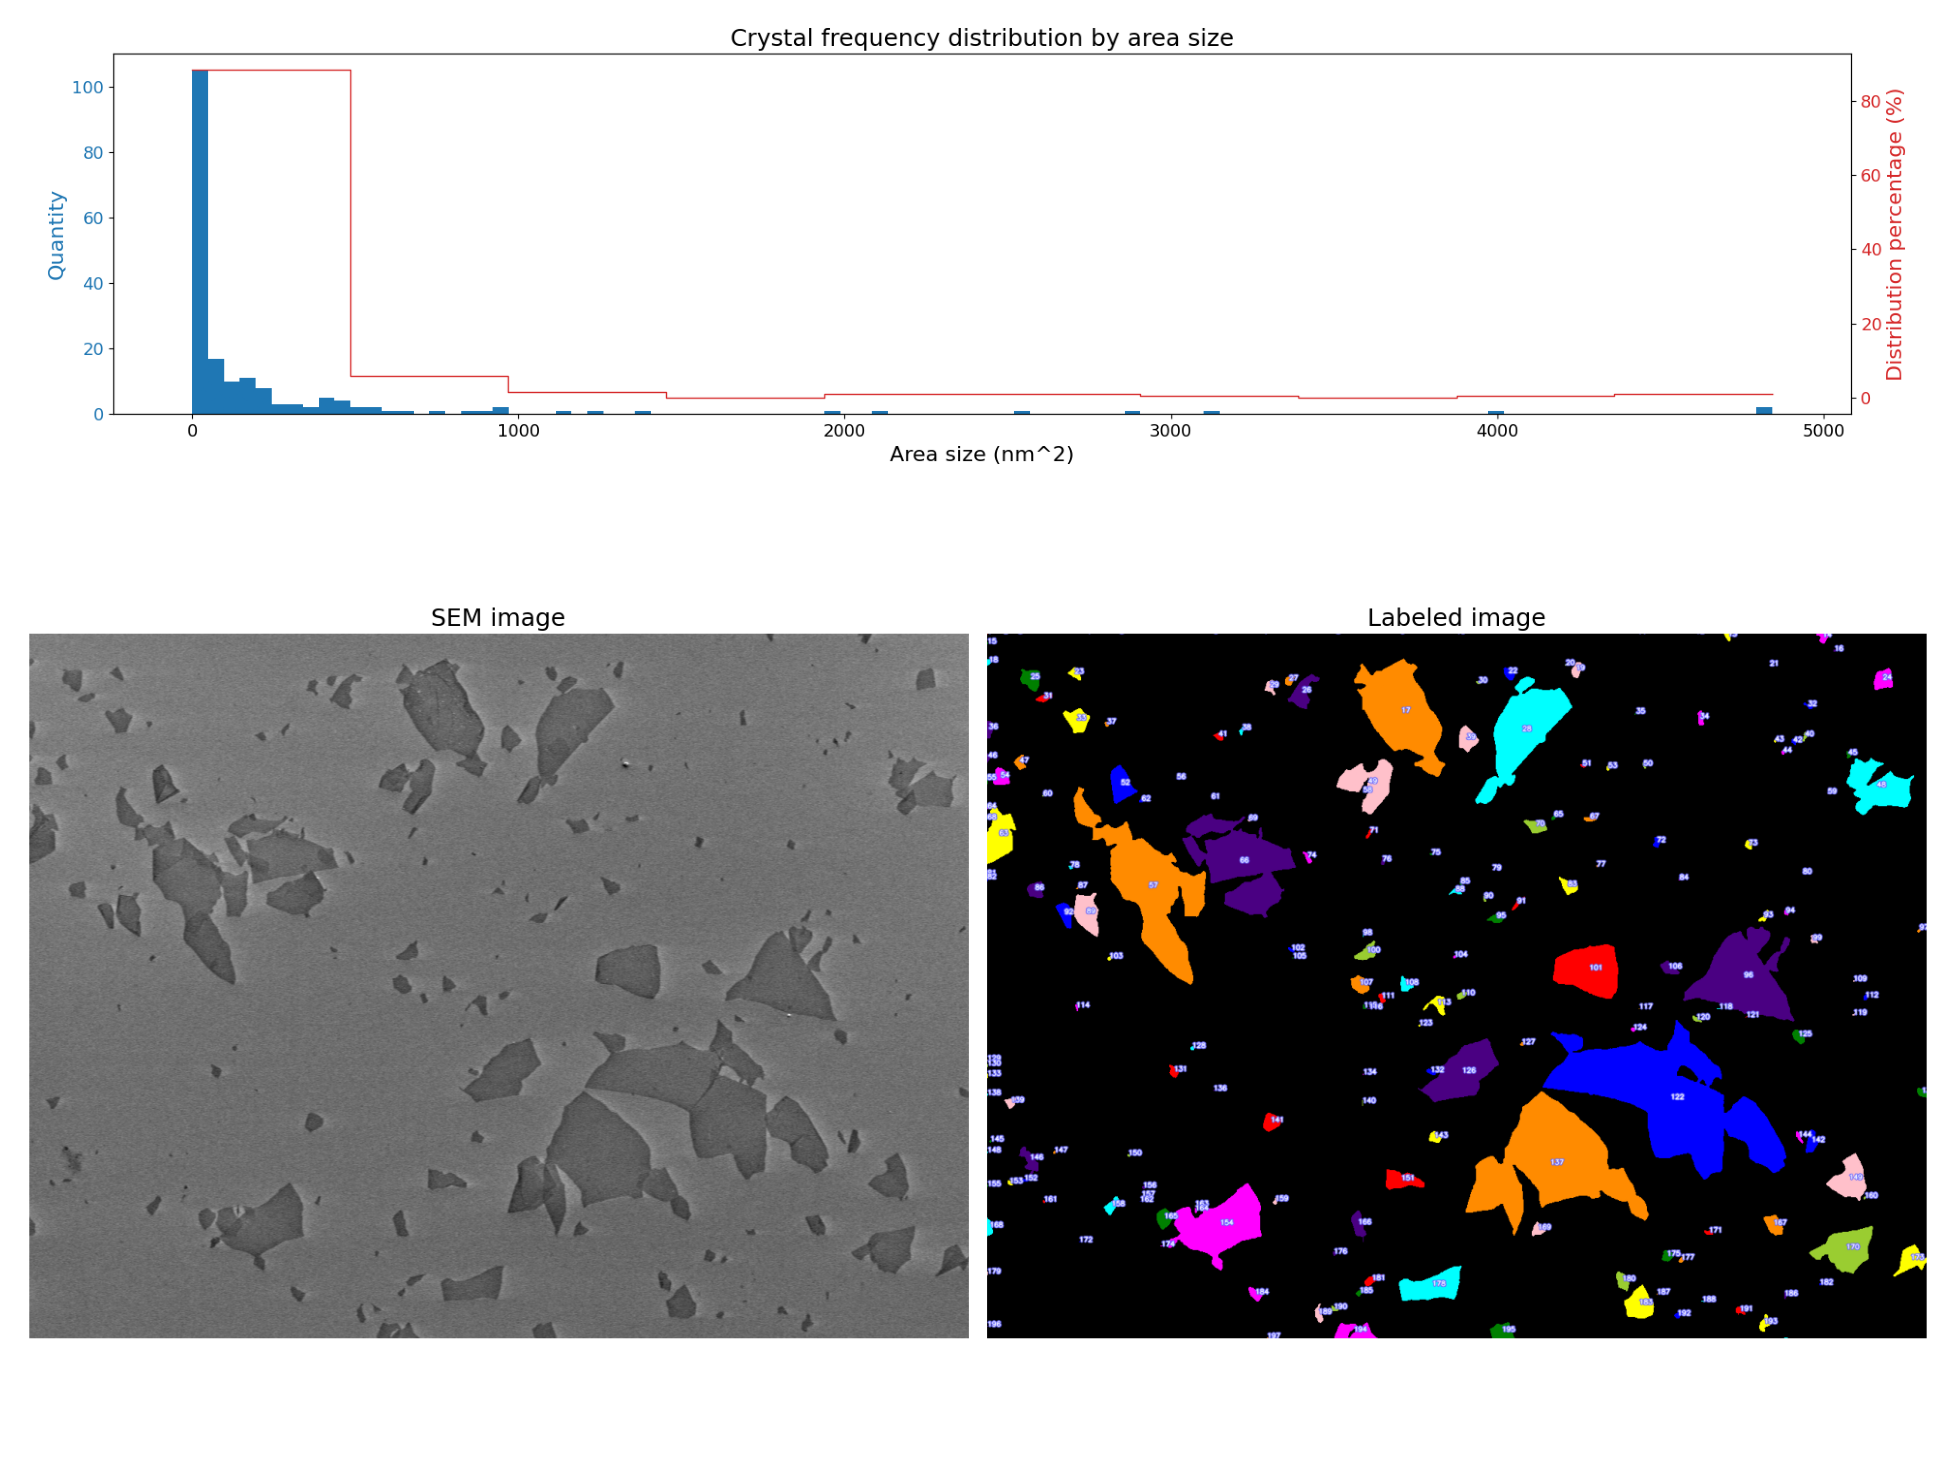

In [11]:
img_result = plt.imread('/content/drive/MyDrive/Colab Notebooks/U-net Graphene Segmentation Final/Image_Proc2.png')
img_graphic = plt.imread('/content/drive/MyDrive/Colab Notebooks/U-net Graphene Segmentation Final/Graphic.png')

plt.figure(figsize=(20, 15))
plt.subplot2grid((3, 1), (0, 0))
plt.imshow(img_graphic)
plt.axis('off')

plt.subplot2grid((3, 1), (1, 0), rowspan=2)
# plt.title('Crystal frequency distribution by area size')
plt.imshow(img_result)
plt.axis('off')

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Colab Notebooks/U-net Graphene Segmentation Final/GO_Caracterization.png')


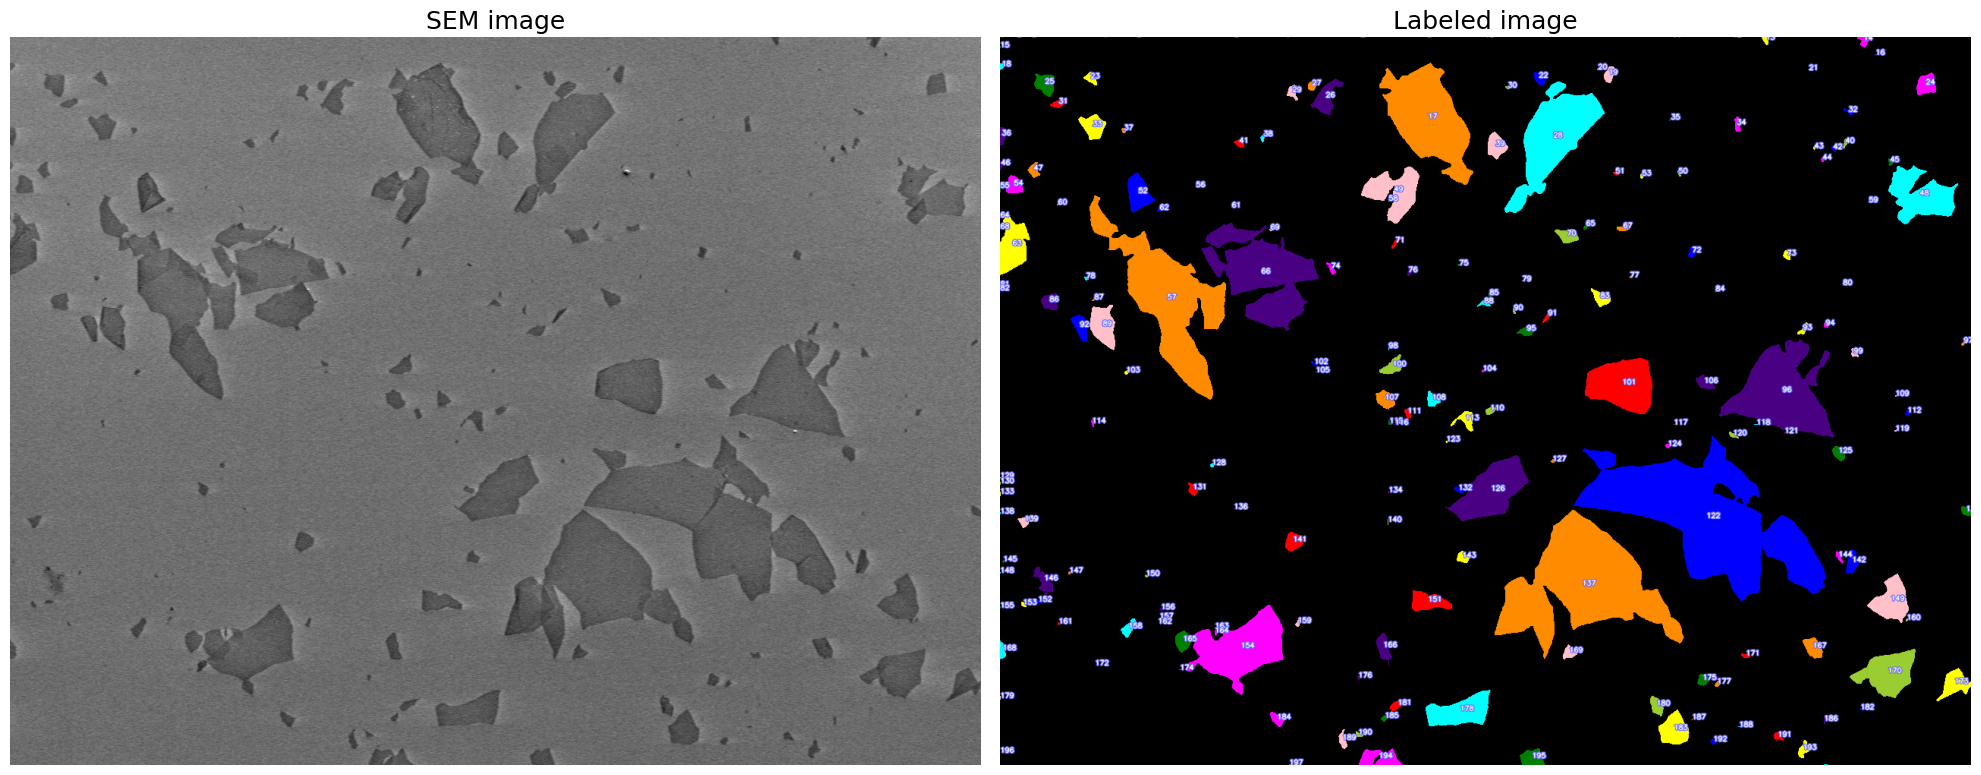

In [12]:
#CLUSTERING, MEASURAMENT AND IDENTIFICATION
from skimage import io
from image_manipulation import measurament

labels, df = measurament(predicted_final)

plt.figure(figsize=(20,10))
plt.subplot(121)
plt.title('SEM image', fontsize=18)
plt.imshow(large_img[:960, :], cmap='gray')
plt.axis('off')

plt.subplot(122)
plt.title('Labeled image', fontsize=18)
plt.imshow(image, cmap='brg')
plt.axis('off')

plt.tight_layout()

plt.savefig('/content/drive/MyDrive/Colab Notebooks/U-net Graphene Segmentation Final/Image_Proc2.png')
plt.show()

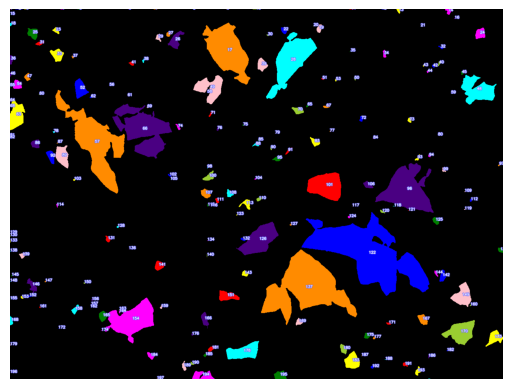

In [13]:
plt.imshow(image, cmap='brg')
plt.axis('off')
plt.savefig('Image_Proc2.png')